# Code for Section 6.2.1 Solving CVaR Problems
This example illustrates how to use the relative market values parameter v in the MeanCVaR class in addition to implementing Entropy Pooling stress-testing of a derivatives portfolio.

It leaves it as an exercise to implement the original CVaR optimization approach and compare it with the results and speed of the implementation from the fortitudo.tech Python package.

Many of the steps in this code are explained in the accompanying video to the Portfolio Management Framework for Derivative Instruments article: https://youtu.be/RnfOzvjWTcU.

This code however focuses strictly on CVaR optimization.

If you are interested in a comparison with variance optimization, see https://github.com/fortitudo-tech/fortitudo.tech/blob/main/examples/5_DerivativesFramework.ipynb.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

from time import time

In [2]:
pnl = ft.load_pnl()
np.round(ft.simulation_moments(pnl), 3)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.007,0.032,0.096,3.023
Corp IG,-0.004,0.034,0.107,3.109
Corp HY,0.019,0.061,0.173,2.971
EM Debt,0.027,0.075,0.217,3.057
DM Equity,0.064,0.149,0.396,3.148
EM Equity,0.080,0.269,0.766,4.099
Private Equity,0.137,0.278,0.716,3.758
Infrastructure,0.059,0.108,0.311,3.193
Real Estate,0.043,0.081,0.234,3.092
Hedge Funds,0.048,0.072,0.204,3.050


In [3]:
# Price some options
put_90 = ft.put_option(1, 0.9, 0.16, 0, 1)
put_95 = ft.put_option(1, 0.95, 0.155, 0, 1)
put_atmf = ft.put_option(1, 1, 0.15, 0, 1)
call_atmf = ft.call_option(1, 1, 0.15, 0, 1)
call_105 = ft.call_option(1, 1.05, 0.145, 0, 1)
call_110 = ft.call_option(1, 1.1, 0.14, 0, 1)

# Compute relative P&L
S, I = pnl.shape
zeros_vec = np.zeros(S)
dm_equity_price = 1 + pnl['DM Equity'].values

put_90_pnl = np.maximum(zeros_vec, 0.9 - dm_equity_price) - put_90
put_95_pnl = np.maximum(zeros_vec, 0.95 - dm_equity_price) - put_95
put_atmf_pnl = np.maximum(zeros_vec, 1 - dm_equity_price) - put_atmf
call_atmf_pnl = np.maximum(zeros_vec, dm_equity_price - 1) - call_atmf
call_105_pnl = np.maximum(zeros_vec, dm_equity_price - 1.05) - call_105
call_110_pnl = np.maximum(zeros_vec, dm_equity_price - 1.1) - call_110

In [4]:
# Add option simulations to P&L
pnl['Put 90'] = put_90_pnl
pnl['Put 95'] = put_95_pnl
pnl['Put ATMF'] = put_atmf_pnl
pnl['Call ATMF'] = call_atmf_pnl
pnl['Call 105'] = call_105_pnl
pnl['Call 110'] = call_110_pnl

stats_prior = ft.simulation_moments(pnl)
np.round(stats_prior, 3)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.007,0.032,0.096,3.023
Corp IG,-0.004,0.034,0.107,3.109
Corp HY,0.019,0.061,0.173,2.971
EM Debt,0.027,0.075,0.217,3.057
DM Equity,0.064,0.149,0.396,3.148
EM Equity,0.080,0.269,0.766,4.099
Private Equity,0.137,0.278,0.716,3.758
Infrastructure,0.059,0.108,0.311,3.193
Real Estate,0.043,0.081,0.234,3.092
Hedge Funds,0.048,0.072,0.204,3.050


# Entropy Pooling views
Same as in the Portfolio Management Framework for Derivative Instruments article: https://ssrn.com/abstract=4217884.

This is just in order to get nonuniform scenario probabilites q for the CVaR exercise below.

In [5]:
dm_eqt_pnl = pnl['DM Equity'].values[np.newaxis, :]
dm_eqt_mean = stats_prior['Mean'].iloc[4]
dm_eqt_demean = dm_eqt_pnl - dm_eqt_mean
p = np.ones((S, 1)) / S

A_ep = np.vstack((
    np.ones((1, S)), dm_eqt_pnl, dm_eqt_demean**2,
    (dm_eqt_demean / 0.2)**3, (dm_eqt_demean / 0.2)**4))
b_ep = np.array([[1.], [dm_eqt_mean], [0.2**2], [-0.1], [2.75]])

q = ft.entropy_pooling(p, A_ep, b_ep)

In [6]:
stats_post = ft.simulation_moments(pnl, q)
np.round(stats_post, 3)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.007,0.032,0.043,2.999
Corp IG,-0.004,0.033,0.152,3.140
Corp HY,0.017,0.071,-0.010,2.792
EM Debt,0.025,0.082,0.083,3.104
DM Equity,0.064,0.200,-0.100,2.750
EM Equity,0.080,0.326,0.571,4.035
Private Equity,0.142,0.339,0.441,3.247
Infrastructure,0.058,0.114,0.303,3.082
Real Estate,0.040,0.090,0.114,2.962
Hedge Funds,0.045,0.093,-0.220,3.012


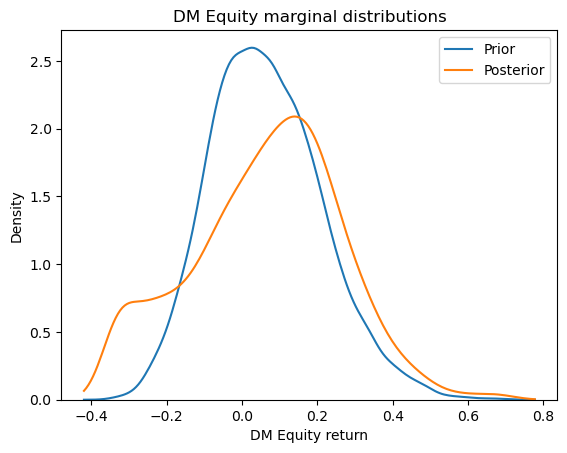

In [7]:
# Plot DM Equity P&L distribution
sns.kdeplot(x=pnl['DM Equity'])
sns.kdeplot(x=pnl['DM Equity'], weights=q[:, 0])
plt.title('DM Equity marginal distributions')
plt.legend(['Prior', 'Posterior'])
plt.xlabel('DM Equity return')
plt.show()

# Prior and posterior portfolio optimization


In [8]:
# Optimization constraints
v = np.hstack((np.ones(I), [put_90, put_95, put_atmf, call_atmf, call_105, call_110]))
G = np.vstack((np.eye(len(v)), -np.eye(len(v))))
options_bounds = 0.5 * np.ones(6)
h = np.hstack((0.25 * np.ones(I), options_bounds, np.zeros(I), options_bounds))

In [9]:
R = pnl.values
alpha = 0.9
ft.cvar_options['demean'] = False  # To avoid confusion in the CVaR exercise below
cvar_opt_prior = ft.MeanCVaR(R, G, h, v=v, alpha=alpha)
cvar_opt_post = ft.MeanCVaR(R, G, h, v=v, p=q, alpha=alpha)

start = time()
port_cvar = cvar_opt_prior.efficient_portfolio(0.05)
print(f'Prior optimization in {np.round(time() - start, 3)} seconds')

start = time()
port_cvar_post = cvar_opt_post.efficient_portfolio(0.05)
print(f'Posterior optimization in {np.round(time() - start, 3)} seconds')

Prior optimization in 0.077 seconds
Posterior optimization in 0.216 seconds


In [10]:
results = np.hstack((port_cvar, port_cvar_post))
pd.DataFrame(
    np.round(100 * results, 2), index=pnl.columns, columns=['Prior', 'Posterior'])

,Prior,Posterior
Gov & MBS,0.00,18.56
Corp IG,-0.00,0.00
Corp HY,0.00,0.00
EM Debt,15.05,7.05
DM Equity,16.81,25.00
EM Equity,-0.00,0.00
Private Equity,4.81,2.70
Infrastructure,18.60,9.94
Real Estate,18.44,9.37
Hedge Funds,25.00,25.00


# Exercise for readers to solve the problem with the original CVaR formulation
This section allows you to validate that you understand how to solve CVaR problems for fully general Monte Carlo distributions using the original linear programming formulation.

A lot of help has been provied to you, so you avoid some common mistakes. You simply need to specify the objectives correctly through the vectors c_prior and c_post as well as the constraints associated with the auxiliary variables y through G_lp and h_lp.

We use the linear programming solver from scipy, because it works directly on numpy arrays, but you are welcome to try out different linear programming solvers. CVXOPT is also available in the pcrm-book environment.

In [11]:
# See docs at https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.optimize.linprog.html
from scipy.optimize import linprog

In [12]:
mu_prior = stats_prior['Mean'].values
mu_post = stats_post['Mean'].values
expected_return_row_prior = np.hstack((-mu_prior, np.zeros(S + 1)))[np.newaxis, :]
expected_return_row_post = np.hstack((-mu_post, np.zeros(S + 1)))[np.newaxis, :]
c_constant = 1 / (1 - alpha)  # you might find this useful in c_prior and c_post
mu_target = 0.05

In [13]:
# Specify the linear programming problems
start = time()
c_prior =  # specify prior objective value here
c_post =  # specify posterior objective value here
A_lp = np.hstack((v, np.zeros(S + 1)))[np.newaxis, :]
b_lp = np.array([1.])
G_lp =  # specify auxiliary variables left-hand side here
h_lp =  # specify auxiliary variables right-hand side here
G_lp_prior = np.vstack((G_lp, np.hstack((G, np.zeros((G.shape[0], S + 1)))), expected_return_row_prior))
h_lp_prior = np.hstack((h_lp, h, -mu_target))
G_lp_post = np.vstack((G_lp, np.hstack((G, np.zeros((G.shape[0], S + 1)))), expected_return_row_post))
h_lp_post = np.hstack((h_lp, h, -mu_target))
print(time() - start)

1.3229694366455078


In [14]:
# Compute optimal exposures
start = time()
e_prior = linprog(c_prior, G_lp_prior, h_lp_prior, A_lp, b_lp, bounds=(None, None))['x'][0:16]
print(time() - start)

start = time()
e_post = linprog(c_post, G_lp_post, h_lp_post, A_lp, b_lp, bounds=(None, None))['x'][0:16]
print(time() - start)

4.0448408126831055
3.121350049972534


In [15]:
# For comparison with the results table above
results_lp = np.hstack((e_prior[:, np.newaxis], e_post[:, np.newaxis]))
pd.DataFrame(
    np.round(100 * results_lp, 2), index=pnl.columns, columns=['Prior', 'Posterior'])

,Prior,Posterior
Gov & MBS,-0.00,18.56
Corp IG,-0.00,-0.00
Corp HY,-0.00,-0.00
EM Debt,15.05,7.05
DM Equity,16.81,25.00
EM Equity,-0.00,-0.00
Private Equity,4.81,2.70
Infrastructure,18.60,9.94
Real Estate,18.44,9.37
Hedge Funds,25.00,25.00


In [ ]:
# pcrm-book - Next generation investment analysis.
# Copyright (C) 2025 Anton Vorobets.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.